In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import curve_fit
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.statespace.sarimax import SARIMAX

https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

# Load Data

In [3]:
data = pd.read_csv("cleanData.csv",index_col=0)

In [4]:
series = data.columns

# Models

## ARIMA

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting M

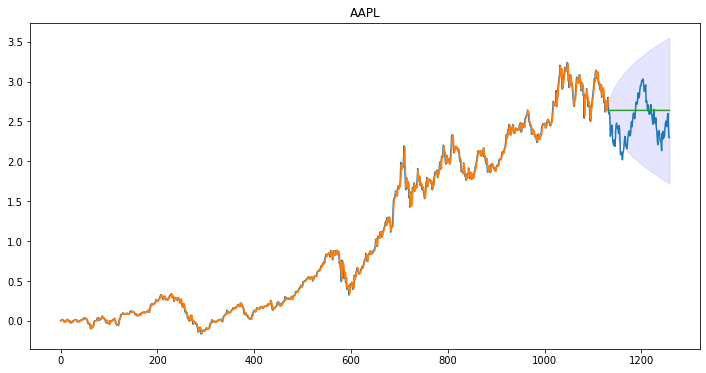

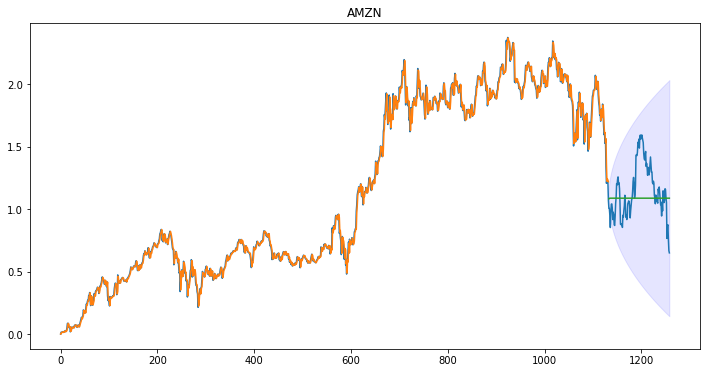

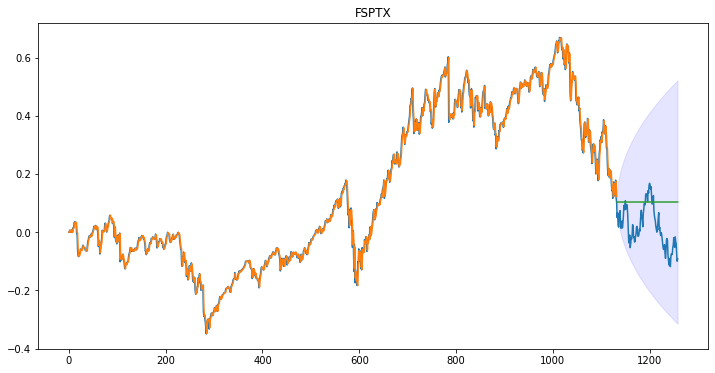

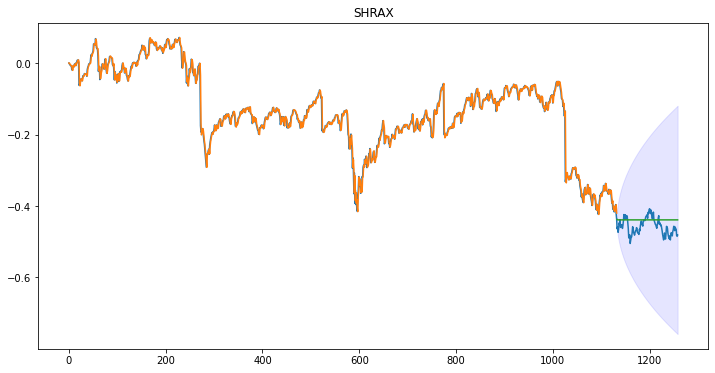

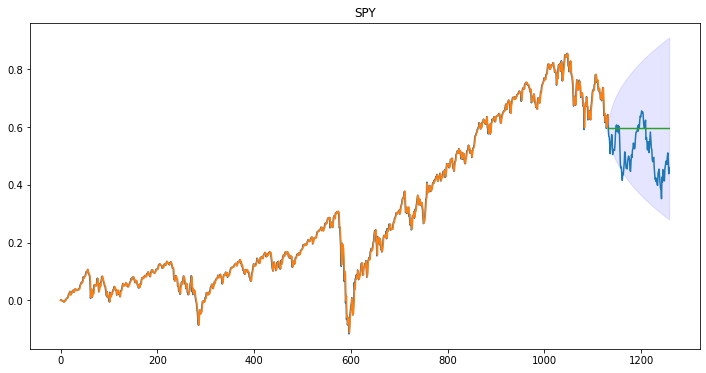

In [129]:
ARIMAError = []
ARIMAConf = []

for i in range(1,len(series)):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)

    trainX = t[:int(.9*len(thisSeries))]
    testX = t[int(.9*len(thisSeries)):]

    trainY = thisSeries[:int(.9*len(thisSeries))]
    testY = thisSeries[int(.9*len(thisSeries)):]

    fit = ARIMA(trainY, order = (2,1,2)).fit()

    forecast = fit.get_forecast(len(testX)).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries)
    plt.plot(trainX,fit.fittedvalues)
    plt.plot(testX, forecast["mean"])
    plt.fill_between(testX,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1)
    plt.title(series[i]);
    ARIMAError.append(MAPE(forecast["mean"],testY))
    ARIMAConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))
    

# Exponential Smoothing

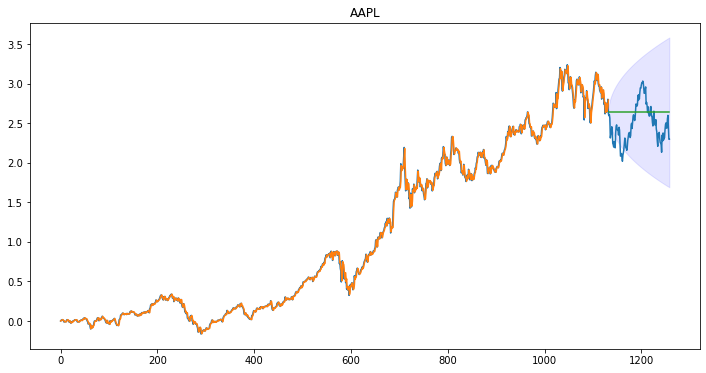

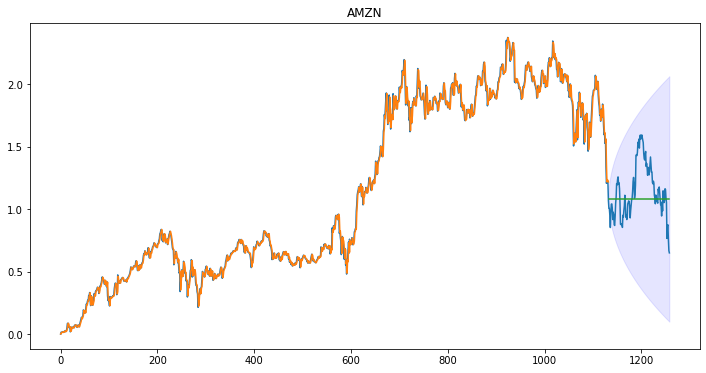

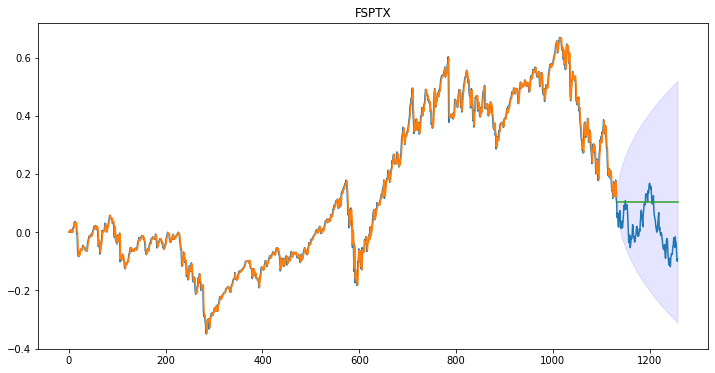

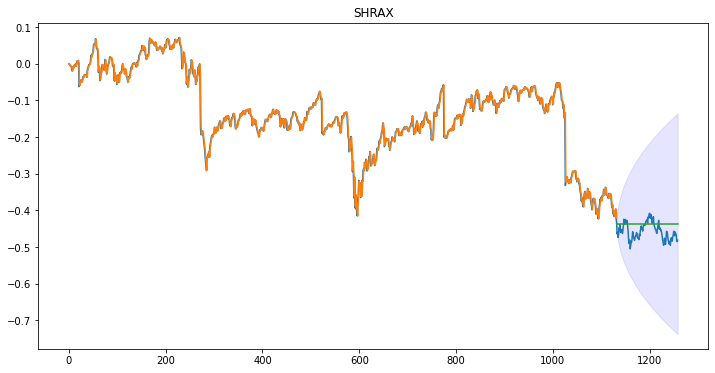

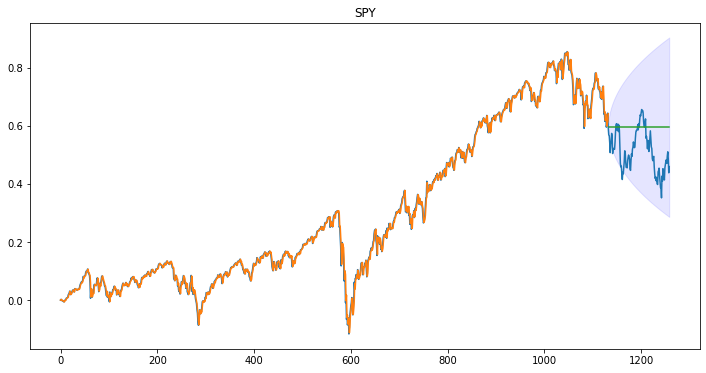

In [130]:
ExpSmoothError = []
ExpSmoothConf = []

for i in range(1,len(series)):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)

    trainX = t[:int(.9*len(thisSeries))]
    testX = t[int(.9*len(thisSeries)):]

    trainY = thisSeries[:int(.9*len(thisSeries))]
    testY = thisSeries[int(.9*len(thisSeries)):]

    fit = ExponentialSmoothing(trainY).fit(disp=0)

    forecast = fit.get_forecast(len(testX)).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries)
    plt.plot(trainX,fit.fittedvalues)
    plt.plot(testX, forecast["mean"])
    plt.fill_between(testX,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1)
    plt.title(series[i]);
    ExpSmoothError.append(MAPE(forecast["mean"],testY))
    ExpSmoothConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))

# Holt's

0.12099960182507671
0.14987597102744396
0.8843056186623817
0.04309358172435329
0.1831422971969853


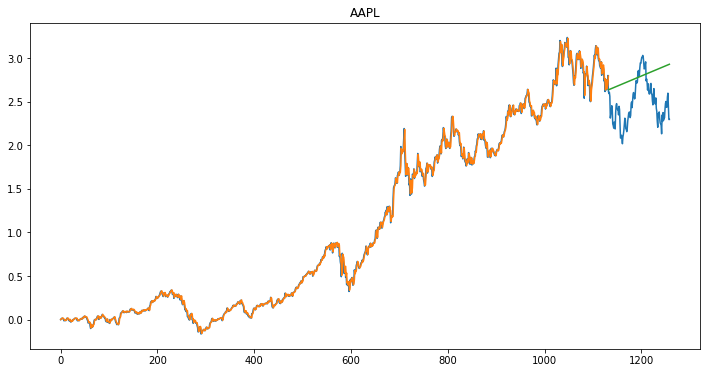

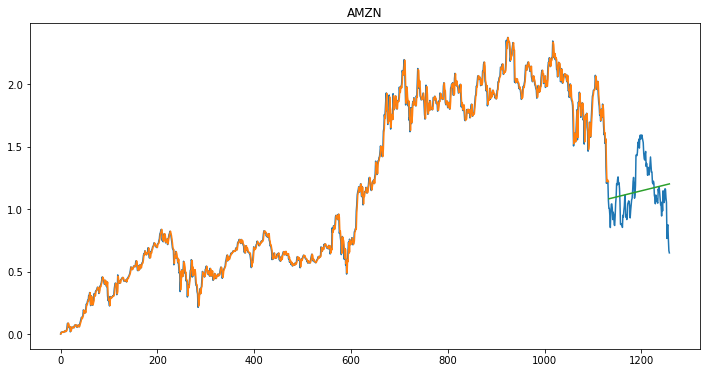

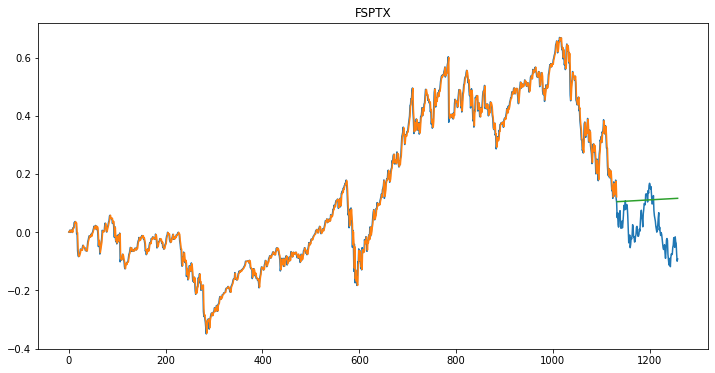

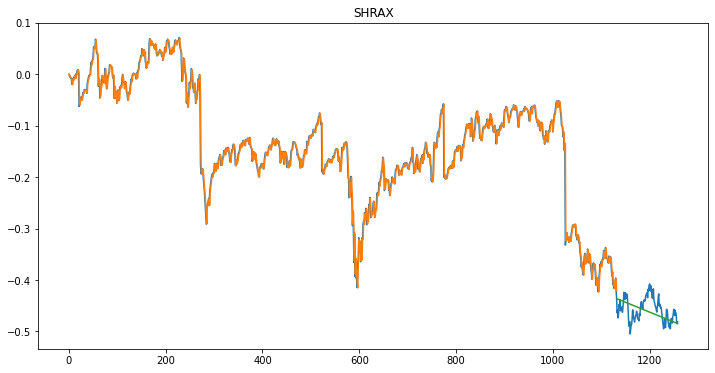

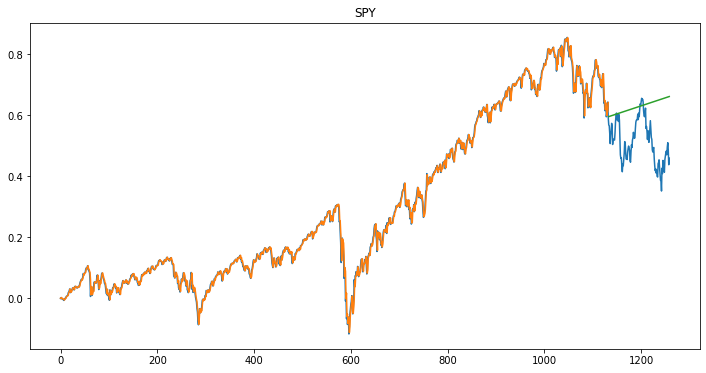

In [128]:
for i in range(1,len(series)):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)

    trainX = t[:int(.9*len(thisSeries))]
    testX = t[int(.9*len(thisSeries)):]

    trainY = thisSeries[:int(.9*len(thisSeries))]
    testY = thisSeries[int(.9*len(thisSeries)):]

    fit = Holt(trainY).fit()

    forecast = fit.forecast(len(testY))
    
    plt.figure(figsize = (12,6))
    ax = plt.subplot(111)

    plt.plot(t,thisSeries)
    plt.plot(trainX,fit.fittedvalues)
    plt.plot(testX, forecast)
    #plt.fill_between(testX,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1)
    plt.title(series[i])
    
    print(MAPE(forecast,testY))

# Analysis

In [131]:
fits = pd.DataFrame(np.array([ARIMAError,ExpSmoothError, ARIMAConf,ExpSmoothConf]).T,
                    columns = ["ARIMA Error", "Exp Smooth Error", "ARIMA Confidence", "Exp Smooth Confidence"])

In [132]:
fits

#ARIMA First 2
#EXP smooth last 3

,ARIMA Error,Exp Smooth Error,ARIMA Confidence,Exp Smooth Confidence
0,0.094164,0.093857,1.229201,1.271768
1,0.157215,0.158441,1.271732,1.320249
2,0.900521,0.899384,0.561932,0.558614
3,0.055222,0.059009,0.427833,0.403584
4,0.149596,0.149917,0.422986,0.414499


# Final Forecasts

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


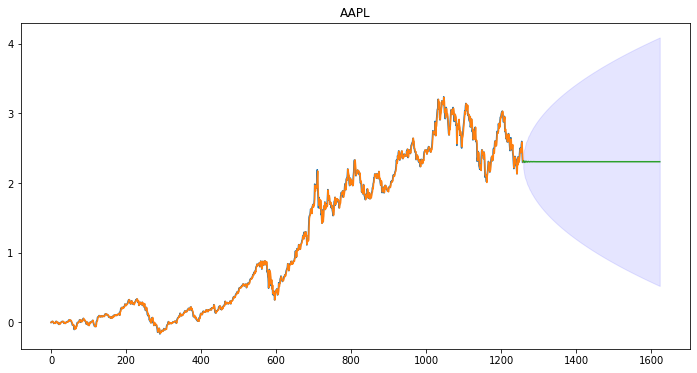

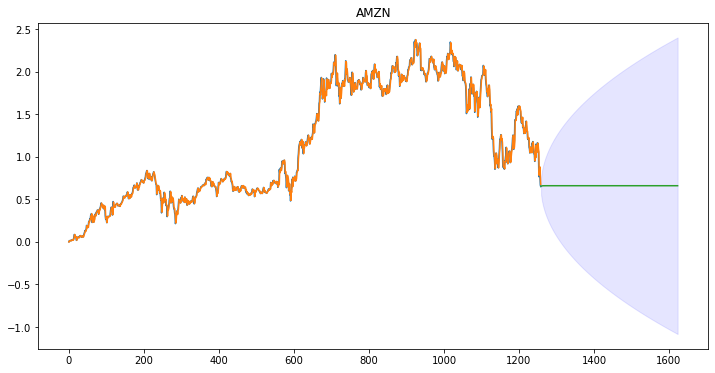

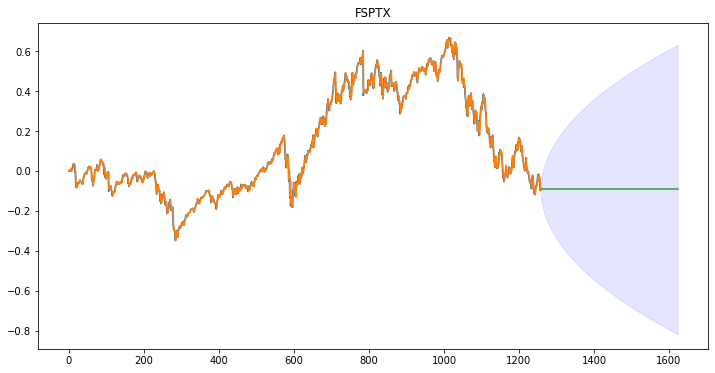

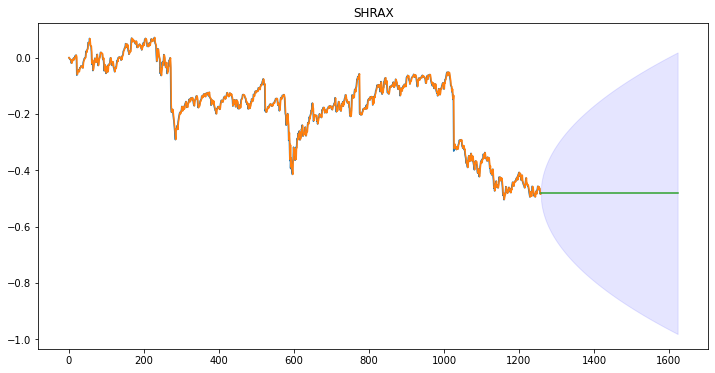

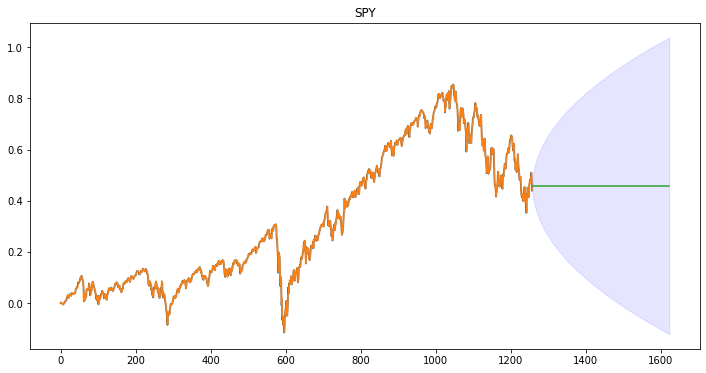

In [145]:
finalForecasts = []
finalConf = []

for i in range(1,3):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)
    forecastT = np.arange(len(thisSeries),len(thisSeries)+365,1)
    fit = ARIMA(thisSeries, order = (2,1,2)).fit()

    forecast = fit.get_forecast(365).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries)
    plt.plot(t,fit.fittedvalues)
    plt.plot(forecastT, forecast["mean"])
    plt.fill_between(forecastT,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1)
    plt.title(series[i]);
    finalForecasts.append(forecast["mean"].iloc[-1] - thisSeries.iloc[-1] )
    finalConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))
    

for i in range(3,6):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)
    forecastT = np.arange(len(thisSeries),len(thisSeries)+365,1)
    fit = ExponentialSmoothing(thisSeries).fit(disp=0)

    forecast = fit.get_forecast(365).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries)
    plt.plot(t,fit.fittedvalues)
    plt.plot(forecastT, forecast["mean"])
    plt.fill_between(forecastT,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1)
    plt.title(series[i]);
    finalForecasts.append(forecast["mean"].iloc[-1] - thisSeries.iloc[-1])
    finalConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))

In [146]:
finalForecasts

[0.009516876978188815,
 0.00955239624893145,
 -0.0004854053132447578,
 -0.00016969440516606538,
 -0.0008352043565477696]